# WORKSHOP INTEGRADOR

<tr><th>Predictor</th><th>Descripción</th></tr>
<tr><td>f0_</td><td>id del usuario</td></tr>
<tr><td>fecha solicitud</td><td>fecha de solicitud de la tarjeta</td></tr>
<tr><td>mes emisión</td><td>mes de la emisión de la tarjeta</td></tr>
<tr><td>flag_seller</td><td>toma el valor de 1 si el usuario es un vendedor y 0 si es un pagador</td></tr>
<tr><td>geo_state</td><td>estado de México</td></tr>
<tr><td>geo_city</td><td>ciudad de México</td></tr>
<tr><td>flag_credito</td><td>tom el valor de 1 si el usuario tomó un crédito</td></tr>
<tr><td>tpn_month</td><td>cantidad de transacciones que el usuario hizo ese mes</td></tr>
<tr><td>tpv_month</td><td>monto total de transacciones que el usuario hizo ese mes</td></tr>
<tr><td>dias_ult</td><td>días desde ultima transaccion </td></tr>
<tr><td>LYLT</td><td>nivel de loyalty del usuario (alto, medio, bajo), un loyalty más alto implica una mayor interaccion en el ecosistema</td></tr>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize

from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from skopt.space import Integer, Real,Categorical
from skopt import BayesSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import pickle
import shap
import plotly.express as px

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

In [5]:
df = pd.read_csv("./Data_DH.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265586 entries, 0 to 265585
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   cus_cust_id          265586 non-null  float64
 1   fecha_solicitud      265586 non-null  object 
 2   flag_seller          265586 non-null  int64  
 3   GEO_STATE            265586 non-null  object 
 4   GEO_CITY             265586 non-null  object 
 5   flag_credito         265586 non-null  int64  
 6   tpn_month            265586 non-null  float64
 7   tpv_month            265586 non-null  float64
 8   tpn_billetera        265586 non-null  float64
 9   tpn_seguros          265586 non-null  float64
 10  tpn_ingresos         265586 non-null  float64
 11  tpn_pagos_online     265586 non-null  float64
 12  tpn_pagos_commerce   265586 non-null  float64
 13  dias_ult             265586 non-null  int64  
 14  flag_actividad       265586 non-null  int64  
 15  flag_wallet      

In [7]:
df.head(10)

cus_cust_id fecha_solicitud  flag_seller                        GEO_STATE  \
0  4.954776e+10         5/12/21            0                 Ciudad de México   
1  7.026086e+10        17/12/21            0                 Ciudad de México   
2  5.820834e+10         8/10/21            0                         Tlaxcala   
3  6.375957e+10        26/11/21            0                          Jalisco   
4  6.934938e+10         30/8/21            0                          Jalisco   
5  7.574593e+10        22/12/21            0                          Jalisco   
6  8.674944e+10         27/8/21            0  Veracruz de Ignacio de la Llave   
7  5.156245e+09        23/10/21            0             Coahuila de Zaragoza   
8  9.850658e+09        12/11/21            0  Veracruz de Ignacio de la Llave   
9  2.083449e+10        23/11/21            0                           Oaxaca   

                                 GEO_CITY  flag_credito  tpn_month  \
0                        Ciudad de México             1     6.7824   
1                        Ciudad de México             0    13.5648   
2                               Zacatelco             1     3.3912   
3                             Guadalajara             1    13.5648   
4                         Puerto Vallarta             0     6.7824   
5                         Lagos de Moreno             0    91.5624   
6                             Las Trancas             0    16.9560   
7                                Monclova             0     6.7824   
8                                Veracruz             0   176.3424   
9  Heroica Ciudad de Juchitán de Zaragoza             1    20.3472   

       tpv_month  tpn_billetera  tpn_seguros  ...  dias_ult  flag_actividad  \
0    1662.272040        0.00000          0.0  ...        49               1   
1    3723.644360        7.74952          0.0  ...         1               1   
2    1162.428000        0.00000          0.0  ...         0               1   
3   14181.621600        3.87476          0.0  ...         0               1   
4     774.952000        0.00000          0.0  ...         0               1   
5   23277.891930       19.37380          0.0  ...         2               1   
6    7596.893204        7.74952          0.0  ...         0               1   
7    6393.354000        0.00000          0.0  ...        36               1   
8  191704.990900       15.49904          0.0  ...         0               1   
9    6025.484286        3.87476          0.0  ...         0               1   

   flag_wallet  flag_seguros  flag_ingresos  flag_pagos_online  \
0            0             0              0                  0   
1            1             0              0                  0   
2            0             0              1                  0   
3            1             0              1                  0   
4            0             0              1                  0   
5            1             0              0                  0   
6            1             0              1                  0   
7            0             0              0                  0   
8            1             0              0                  0   
9            1             0              1                  0   

   flag_pagos_commerce   LYLT  flag_activacion_td  fecha_activacion_td  
0                    0   Bajo                   1             19/12/21  
1                    1   Bajo                   0                  NaN  
2                    0  Medio                   0                  NaN  
3                    0   Bajo                   1             12/12/21  
4                    0   Alto                   1             26/12/21  
5                    1  Medio                   0                  NaN  
6                    1   Bajo                   1              17/9/21  
7                    0   Alto                   0                  NaN  
8                    1   Alto                   1               8/1/22  
9             

In [8]:
df.GEO_CITY.value_counts(normalize=True)

Ciudad de México                                0.115718
Sin_data                                        0.068701
Juárez                                          0.016718
Heroica Puebla de Zaragoza                      0.016285
Ecatepec de Morelos                             0.015882
                                                  ...   
Manuel Buendía Téllez Girón                     0.000004
Poblado C-21 Licenciado Benito Juárez García    0.000004
Las Garzas                                      0.000004
Las Trojas                                      0.000004
Monte Largo 1ra. Sección                        0.000004
Name: GEO_CITY, Length: 7930, dtype: float64

In [9]:
df.GEO_STATE.value_counts()

Estado de México                   38938
Ciudad de México                   30733
Veracruz de Ignacio de la Llave    19674
Jalisco                            16533
Nuevo León                         13117
Guanajuato                         10384
Puebla                             10017
Tamaulipas                          9282
Chihuahua                           8692
Baja California                     7598
Quintana Roo                        7426
Coahuila de Zaragoza                7386
Michoacán de Ocampo                 6600
Sonora                              6342
Tabasco                             6254
Querétaro                           5891
Chiapas                             5555
Hidalgo                             5406
Oaxaca                              5288
Sinaloa                             5227
Yucatán                             5040
Guerrero                            4806
Morelos                             4772
San Luis Potosí                     4415
Durango         

In [10]:
df.flag_activacion_td.value_counts(normalize=True)

0    0.551373
1    0.448627
Name: flag_activacion_td, dtype: float64

In [11]:
df_dum = pd.get_dummies(df, columns=["LYLT", "GEO_STATE"], drop_first=True)

In [12]:
X = df_dum.drop(columns=["flag_activacion_td", "cus_cust_id", "fecha_solicitud","GEO_CITY", "fecha_activacion_td", "flag_actividad"], axis=1)

In [13]:
X.shape

(265586, 48)

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265586 entries, 0 to 265585
Data columns (total 48 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   flag_seller                                265586 non-null  int64  
 1   flag_credito                               265586 non-null  int64  
 2   tpn_month                                  265586 non-null  float64
 3   tpv_month                                  265586 non-null  float64
 4   tpn_billetera                              265586 non-null  float64
 5   tpn_seguros                                265586 non-null  float64
 6   tpn_ingresos                               265586 non-null  float64
 7   tpn_pagos_online                           265586 non-null  float64
 8   tpn_pagos_commerce                         265586 non-null  float64
 9   dias_ult                                   265586 non-null  int64  
 10  flag_wal

In [15]:
y = df_dum.flag_activacion_td

In [16]:
# Separamos un set de testeo para evaluar el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0, test_size=0.3)

## Naive Bayes

In [17]:
pasos1 = [('scaler', StandardScaler()),('gnb', GaussianNB())]
pipe1 = Pipeline(pasos1)
pipe1.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('gnb', GaussianNB())])

In [18]:
# Lo evaluo en CV
folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)
score_nb = cross_val_score(pipe1, X=X_train, y=y_train, cv=folds, scoring="roc_auc").mean()
score_nb

0.5648799449578594

### LGB

In [19]:
pasos2 = [('scaler', StandardScaler()),('lgb', lgb.LGBMClassifier())]
pipe2 = Pipeline(pasos2)
pipe2.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lgb', LGBMClassifier())])

In [20]:
folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)
score_lgb = cross_val_score(pipe2, X=X_train, y=y_train, cv=folds, scoring="roc_auc").mean()
score_lgb

0.6073338151853478

In [21]:
lgb_select = pd.DataFrame({'atributo':X_train.columns, 'importancia': pipe2.named_steps.lgb.feature_importances_})
lgb_select.sort_values('importancia', ascending = True).iloc[0:4, :]

atributo  importancia
11        flag_seguros            0
13   flag_pagos_online            0
12       flag_ingresos            0
19  GEO_STATE_Campeche            1

In [22]:
lgb_select.sort_values('importancia', ascending=False).iloc[0:5, :]

atributo  importancia
3      tpv_month          678
2      tpn_month          504
4  tpn_billetera          266
6   tpn_ingresos          235
9       dias_ult          231

### LGB + Random

In [23]:
# Carga de modelo entrenado
clf = pickle.load(open("model.sav", 'rb'))

In [24]:
pasos3 = [('scaler', StandardScaler()), ('lgb', lgb.LGBMClassifier())]
pipe3 = Pipeline(pasos3)

In [25]:
search_space = {'lgb__learning_rate': Real(0.01, 0.3, 'uniform'),
                 'lgb__max_depth': Integer(3, 12),
                 'lgb__subsample': Real(0.1, 1.0, 'uniform'),
                "lgb__num_leaves": Integer(20,3000),
                 'lgb__colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'lgb__reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'lgb__reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'lgb__n_estimators': Integer(50, 1000),
                "lgb__min_child_samples": Integer(200,10000),
                "lgb__min_split_gain": Integer(0,15)
   }

In [26]:
folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

#Instanciamos el objeto BayesSearchCV
# clf = BayesSearchCV(
#     pipe3,
#     search_spaces=search_space,
#     scoring='roc_auc',
#     cv=folds,
#     random_state=42, n_jobs=-1
# )

In [27]:
# clf.fit(X_train,y_train)

In [28]:
print("ROC_AUC: ",clf.best_score_)

ROC_AUC:  0.6077946901732082


In [29]:
#Primera corrida
clf_select = pd.DataFrame({'atributo':X_train.columns, 'importancia': clf.best_estimator_.named_steps.lgb.feature_importances_})
clf_select.sort_values('importancia', ascending = True).head(15)

atributo  importancia
47   GEO_STATE_Zacatecas            0
25     GEO_STATE_Durango            0
32     GEO_STATE_Morelos            0
11          flag_seguros            0
13     flag_pagos_online            0
5            tpn_seguros            1
19    GEO_STATE_Campeche            1
14   flag_pagos_commerce            1
12         flag_ingresos            1
10           flag_wallet            1
27  GEO_STATE_Guanajuato            1
44    GEO_STATE_Tlaxcala            7
36      GEO_STATE_Puebla            9
33     GEO_STATE_Nayarit            9
20     GEO_STATE_Chiapas            9

In [30]:
clf_select.sort_values('importancia', ascending = False).head(5)

atributo  importancia
3      tpv_month         1493
2      tpn_month          795
9       dias_ult          401
4  tpn_billetera          381
6   tpn_ingresos          300

In [31]:
clf.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('lgb',
                 LGBMClassifier(colsample_bytree=0.9544535088567576,
                                learning_rate=0.3, max_depth=6,
                                min_child_samples=200, min_split_gain=0,
                                n_estimators=1000, num_leaves=849,
                                reg_alpha=20.425330677451015,
                                reg_lambda=52.73124749072554,
                                subsample=0.5166639624951141))])

pipeline(steps=[('scaler', StandardScaler()),
                ('lgb',
                 LGBMClassifier(colsample_bytree=0.6446195774886868,
                                learning_rate=0.01, max_depth=7,
                                min_child_samples=1464, min_split_gain=0,
                                n_estimators=1000, reg_alpha=1e-09,
                                reg_lambda=1.3020731356798025,
                                subsample=0.9275665993344316))])

In [32]:
# Guardar el modelo LGB + OPT
# import pickle
# filename = 'model.sav'
# pickle.dump(clf, open(filename, 'wb'))

### Evaluación de modelos

In [33]:
print("ROC_AUC NB:", round(score_nb,4))
print("ROC_AUC LGB:", round(score_lgb,4))
print("ROC_AUC LGB + Opt.Bayesina:",round(clf.best_score_,4))

ROC_AUC NB: 0.5649
ROC_AUC LGB: 0.6073
ROC_AUC LGB + Opt.Bayesina: 0.6078


In [34]:
#Probabilidades de NB
y_train_proba_nb = pipe1.predict_proba(X_train)
fpr_log_nb,tpr_log_nb,thr_log_nb = roc_curve(y_train, y_train_proba_nb[:,1])
df_nb = pd.DataFrame(dict(fpr=fpr_log_nb , tpr= tpr_log_nb, thr = thr_log_nb))

In [35]:
#Probabilidades de LGB
y_train_proba_lgb = pipe2.predict_proba(X_train)
fpr_log_lgb,tpr_log_lgb,thr_log_lgb = roc_curve(y_train, y_train_proba_lgb[:,1])
df_lgb = pd.DataFrame(dict(fpr=fpr_log_lgb , tpr= tpr_log_lgb, thr = thr_log_lgb))

In [36]:
#Probabilidades de LGB + OPT
y_train_proba_clf = clf.predict_proba(X_train)
fpr_log_clf,tpr_log_clf,thr_log_clf = roc_curve(y_train, y_train_proba_clf[:,1])
df_clf = pd.DataFrame(dict(fpr=fpr_log_clf , tpr= tpr_log_clf, thr = thr_log_clf))

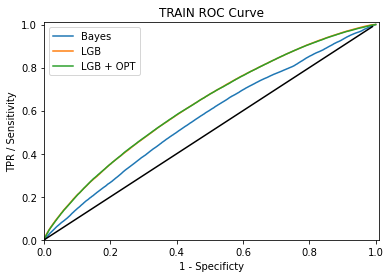

In [37]:
plt.plot(df_nb['fpr'],df_nb['tpr'], label='Bayes')
plt.plot(df_lgb['fpr'],df_lgb['tpr'], label='LGB')
plt.plot(df_clf['fpr'],df_clf['tpr'], label='LGB + OPT')

plt.axis([0, 1.01, 0, 1.01]); plt.legend()
plt.xlabel('1 - Specificty'); plt.ylabel('TPR / Sensitivity'); plt.title('TRAIN ROC Curve')
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), "k")
plt.show()

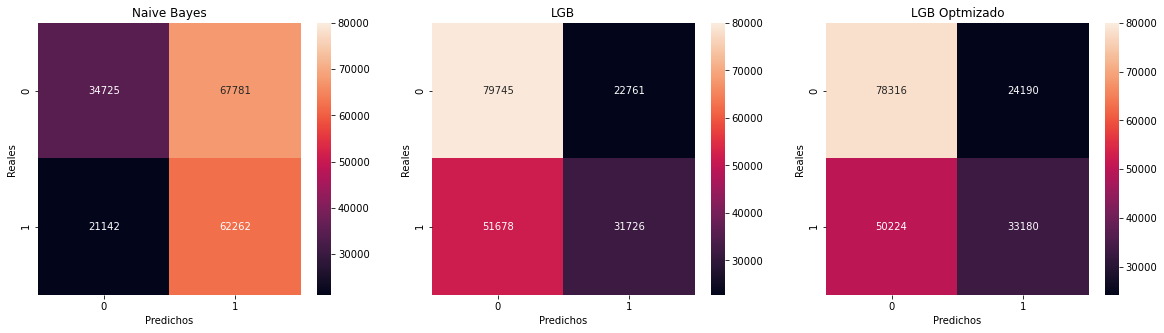

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
sns.heatmap(confusion_matrix(y_train, pipe1.predict(X_train)), annot=True, fmt='4d', vmax=80000, ax=axes[0])
axes[0].set_title("Naive Bayes")
axes[0].set(xlabel="Predichos", ylabel="Reales")

sns.heatmap(confusion_matrix(y_train, pipe2.predict(X_train)), annot=True, fmt='4d', vmax=80000, ax=axes[1])
axes[1].set_title("LGB")
axes[1].set(xlabel="Predichos", ylabel="Reales")

sns.heatmap(confusion_matrix(y_train, clf.predict(X_train)), annot=True, fmt='4d', vmax=80000, ax=axes[2])
axes[2].set_title("LGB Optmizado")
axes[2].set(xlabel="Predichos", ylabel="Reales");

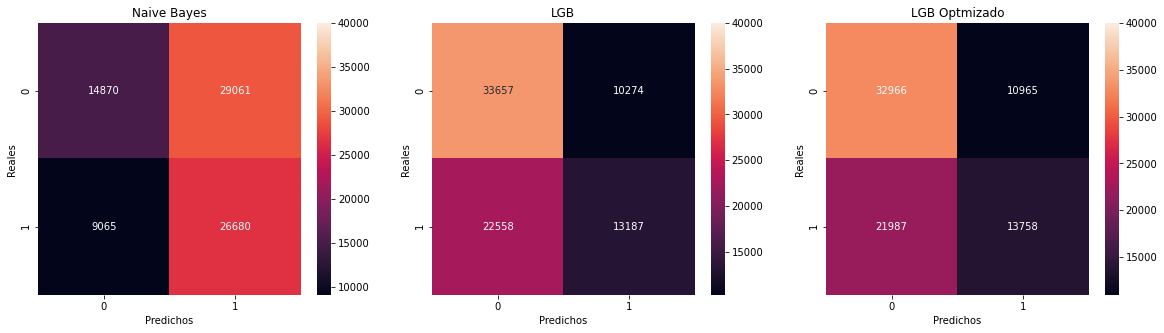

In [39]:
# NO incluir en la entrega
fig, axes = plt.subplots(1, 3, figsize=(20,5))
sns.heatmap(confusion_matrix(y_test, pipe1.predict(X_test)), annot=True, fmt='4d', vmax=40000, ax=axes[0])
axes[0].set_title("Naive Bayes")
axes[0].set(xlabel="Predichos", ylabel="Reales")

sns.heatmap(confusion_matrix(y_test, pipe2.predict(X_test)), annot=True, fmt='4d', vmax=40000, ax=axes[1])
axes[1].set_title("LGB")
axes[1].set(xlabel="Predichos", ylabel="Reales")

sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), annot=True, fmt='4d', vmax=40000, ax=axes[2])
axes[2].set_title("LGB Optmizado")
axes[2].set(xlabel="Predichos", ylabel="Reales");

Por poco el mejor modelo es el optimizado... veamos si con feature selection mejora la performance
Elimino las features con nula a baja importancia

In [40]:
filtro = clf_select[clf_select.importancia > 1].atributo.values

In [41]:
# Carga de modelo entrenado
clf_filtered = pickle.load(open("model_final.sav", 'rb'))

In [42]:
# folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)
# pipe3 = Pipeline(pasos3)

# #Instanciamos el objeto BayesSearchCV
# clf_filtered = BayesSearchCV(
#     pipe3,
#     search_spaces=search_space,
#     scoring='roc_auc',
#     cv=folds,
#     random_state=42, n_jobs=-1
# )

In [43]:
# clf_filtered.fit(X_train[filtro],y_train)

In [44]:
print("ROC_AUC: ",round(clf_filtered.best_score_,4))

ROC_AUC:  0.6087


In [45]:
#Probabilidades de LGB + OPT + FS
y_train_proba_clf_filtered = clf_filtered.predict_proba(X_train[filtro])
fpr_log_clf_filtered,tpr_log_clf_filtered,thr_log_clf_filtered = roc_curve(y_train, y_train_proba_clf_filtered[:,1])
df_clf_filtered = pd.DataFrame(dict(fpr=fpr_log_clf_filtered , tpr= tpr_log_clf_filtered, thr = thr_log_clf_filtered))

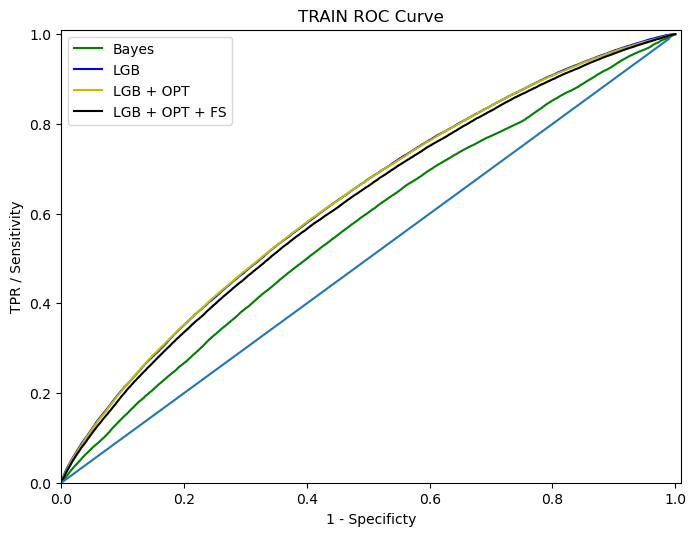

In [46]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(df_nb['fpr'],df_nb['tpr'], "g", label='Bayes')
plt.plot(df_lgb['fpr'],df_lgb['tpr'], "b", label='LGB')
plt.plot(df_clf['fpr'],df_clf['tpr'], "y", label='LGB + OPT')
plt.plot(df_clf_filtered['fpr'],df_clf_filtered['tpr'], "k", label='LGB + OPT + FS')

plt.axis([0, 1.01, 0, 1.01]); plt.legend()
plt.xlabel('1 - Specificty'); plt.ylabel('TPR / Sensitivity'); plt.title('TRAIN ROC Curve')
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [47]:
score_models = pd.DataFrame({"score":[round(score_nb,4),round(score_lgb,4),round(clf.best_score_,4), round(clf_filtered.best_score_,4)], "modelo":["Naive Bayes", "LightGBM base", "LightGBM Optimizado", "LightGBM OPT c/ Feature Selection"]})

In [48]:
fig = px.bar(data_frame = score_models, x = "modelo", y = "score", text = "score",
             title="ROC_AUC score train por modelo", range_y=[0.55,0.61], color = score_models.index, color_continuous_scale=px.colors.sequential.Bluered,
             width=800, height=500)
fig.show()

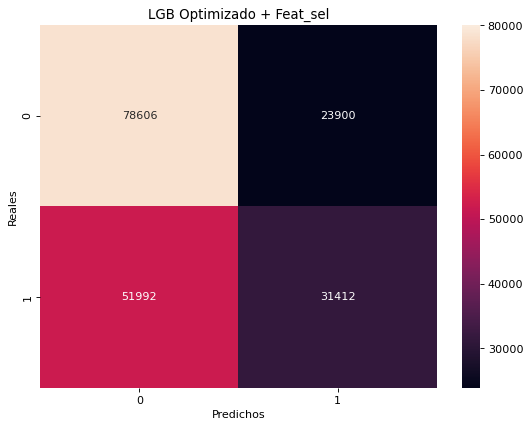

In [49]:
plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(confusion_matrix(y_train, clf_filtered.predict(X_train[filtro])), annot=True, fmt='4d', vmax=80000)
plt.title("LGB Optimizado + Feat_sel")
plt.xlabel('Predichos');
plt.ylabel('Reales');

In [50]:
score_finales = pd.DataFrame({"score":[round(clf_filtered.best_score_,4), round(roc_auc_score(y_test, clf_filtered.predict(X_test[filtro])),2)], "Datos":["Train", "Test"]})

In [51]:
fig = px.bar(data_frame = score_finales, x = "Datos", y = "score", text = "score",
             title="ROC_AUC score LGBM", width=500, height=400, range_y=[0.55,0.61], color="score",color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [52]:
roc_auc_score(y_test, clf_filtered.predict(X_test[filtro]))

0.5680119291713831

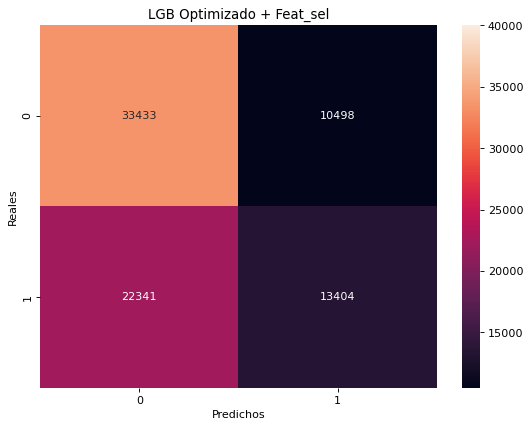

In [53]:
plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(confusion_matrix(y_test, clf_filtered.predict(X_test[filtro])), annot=True, fmt='4d', vmax=40000)
plt.title("LGB Optimizado + Feat_sel")
plt.xlabel('Predichos');
plt.ylabel('Reales');

In [54]:
# import pickle
# filename = 'model_final.sav'
# pickle.dump(clf_filtered, open(filename, 'wb'))

### Feature importance

In [55]:
clf_select_filtered = pd.DataFrame({'atributo':X_train[filtro].columns, 'importancia': clf_filtered.best_estimator_.named_steps.lgb.feature_importances_})
clf_select_filtered.sort_values('importancia', ascending = False).head(10)

atributo  importancia
3            tpv_month         3870
2            tpn_month         2856
5         tpn_ingresos         1672
4        tpn_billetera         1652
7   tpn_pagos_commerce         1374
8             dias_ult         1147
9            LYLT_Bajo          910
10          LYLT_Medio          549
1         flag_credito          525
0          flag_seller          468

In [56]:
fig_imp = px.bar(data_frame = clf_select_filtered.sort_values('importancia', ascending = True).tail(14), y = "atributo", x = "importancia", 
             title="Feature Importance",
             width=800, height=500, color = "importancia", color_continuous_scale=px.colors.sequential.Viridis)
fig_imp.update_layout(xaxis_title = 'Importancia', yaxis_title = 'Feature')             
fig_imp.show()  

In [57]:
X_train.loc[:,"LYLT_Bajo":] = X_train.loc[:,"LYLT_Bajo":].astype(np.int).copy()

C:\Users\ariel.dapia\anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\indexing.py:1715: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
# explainer = shap.TreeExplainer(clf_filtered.best_estimator_.named_steps.lgb)
explainer = pickle.load(open("explainer.sav", 'rb'))

In [59]:
shap.force_plot(explainer.expected_value[1], explainer.shap_values(pd.DataFrame([np.zeros(37)], columns=filtro))[1][0,:], pd.DataFrame([np.zeros(37)], columns=filtro).iloc[0,:], link="logit")

C:\Users\ariel.dapia\anaconda3\envs\dhdsblend2021\lib\site-packages\shap\explainers\_tree.py:351: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



In [60]:
explainer.shap_values(pd.DataFrame([np.zeros(37)], columns=filtro))[1][0,:]

array([-1.93026071e-02, -1.76690537e-02, -8.47288083e-02, -5.78759187e-02,
        4.67593871e-02,  1.53407776e-02,  3.12444102e-03, -3.99987339e-02,
        6.88167667e-02,  7.91010365e-02,  8.56492680e-02, -5.67220865e-04,
        0.00000000e+00,  2.04113220e-03, -2.59662062e-03, -1.49399136e-02,
       -3.32166313e-03,  0.00000000e+00, -1.30949691e-03,  3.75864623e-03,
        1.79134606e-03,  6.72660645e-03,  5.26370146e-03,  0.00000000e+00,
       -8.48085596e-03,  4.47540256e-03,  4.96561050e-05, -4.63136185e-03,
       -3.53920677e-03, -1.62416667e-03,  2.83810509e-03, -6.17656486e-03,
        2.84483155e-03, -1.77957907e-03,  0.00000000e+00,  2.35932652e-03,
       -7.02672272e-04])

In [61]:
# shap_values = explainer.shap_values(X_train[filtro], y_train)
shap_values = pickle.load(open("shap_values.sav", 'rb'))

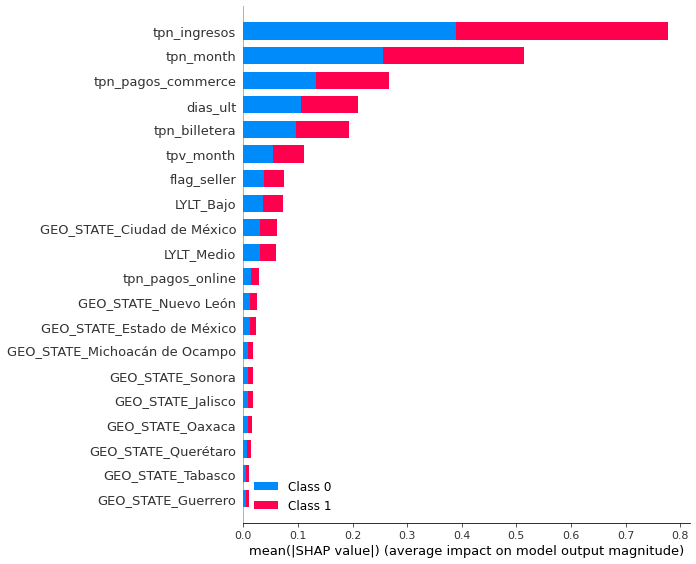

In [62]:
shap.summary_plot(shap_values, X_train[filtro], plot_type="bar")

In [73]:
shap.initjs()

In [74]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_train[filtro].iloc[:1000,:])

In [65]:
#shap.decision_plot(explainer.expected_value[1], shap_values[1], X_train[filtro], ignore_warnings=True)

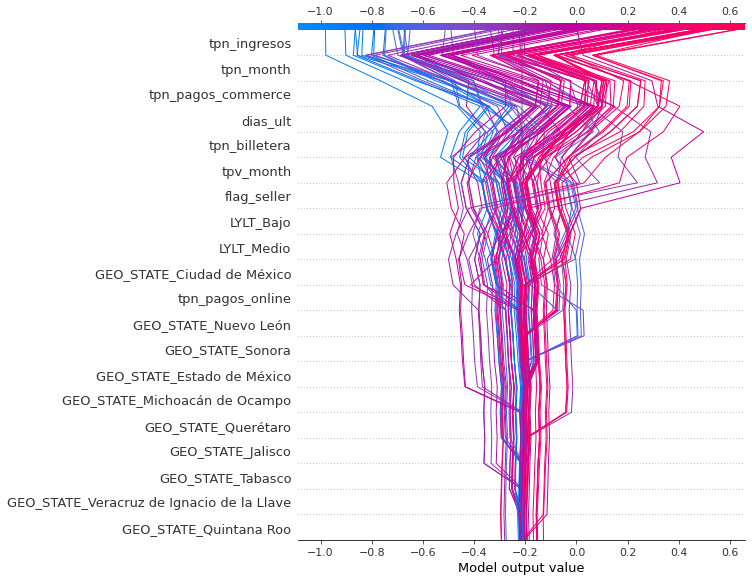

In [66]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][0:100,:], X_train[filtro].iloc[0:100])

In [68]:
def plot_shape_influence(data_position):    
    print("Probabilidad de activar:", round(clf_filtered.predict_proba(X_train[filtro].iloc[[data_position]])[0][1],2))
    return shap.force_plot(explainer.expected_value[1], shap_values[1][data_position,:], X_train[filtro].iloc[data_position,:], link="logit")


In [69]:
l = []
for x in clf_filtered.predict_proba(X_train[filtro]):
    l.append(round(x[0],2))
print("argmax",np.argmax(l))
print("argmin",np.argmin(l))

argmax 20559
argmin 49260


In [70]:
plot_shape_influence(20559)

Probabilidad de activar: 0.2


In [71]:
plot_shape_influence(49260)

Probabilidad de activar: 0.75


# Tiempo de activación 

In [66]:
acti = df[df.flag_activacion_td == 1]

In [67]:
acti['fecha_solicitud'] = pd.to_datetime(acti['fecha_solicitud'])
acti['fecha_activacion_td'] = pd.to_datetime(acti['fecha_activacion_td'])

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/2172884796.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/2172884796.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
acti.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119149 entries, 0 to 265585
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   cus_cust_id          119149 non-null  float64       
 1   fecha_solicitud      119149 non-null  datetime64[ns]
 2   flag_seller          119149 non-null  int64         
 3   GEO_STATE            119149 non-null  object        
 4   GEO_CITY             119149 non-null  object        
 5   flag_credito         119149 non-null  int64         
 6   tpn_month            119149 non-null  float64       
 7   tpv_month            119149 non-null  float64       
 8   tpn_billetera        119149 non-null  float64       
 9   tpn_seguros          119149 non-null  float64       
 10  tpn_ingresos         119149 non-null  float64       
 11  tpn_pagos_online     119149 non-null  float64       
 12  tpn_pagos_commerce   119149 non-null  float64       
 13  dias_ult      

In [69]:
acti["dif_days"] = acti.fecha_activacion_td - acti.fecha_solicitud

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/3881616332.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
acti["days"] = acti["dif_days"].dt.days

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/2710279177.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
# que hacemos con estos casos??
acti[acti.days <0][["days"]]

days
12       -27
45       -18
46       -48
76      -139
79      -198
...      ...
265501   -44
265536   -10
265548   -39
265549  -270
265577  -251

[14923 rows x 1 columns]

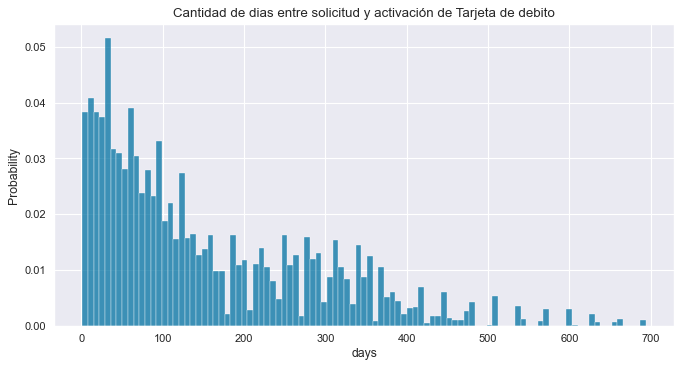

In [146]:
plt.figure(figsize=(10,5), dpi=80)
sns.set_style("darkgrid")
sns.histplot(data=acti[acti.days >=0], x="days", stat="probability", binwidth=7)
plt.title("Cantidad de dias entre solicitud y activación de Tarjeta de debito");

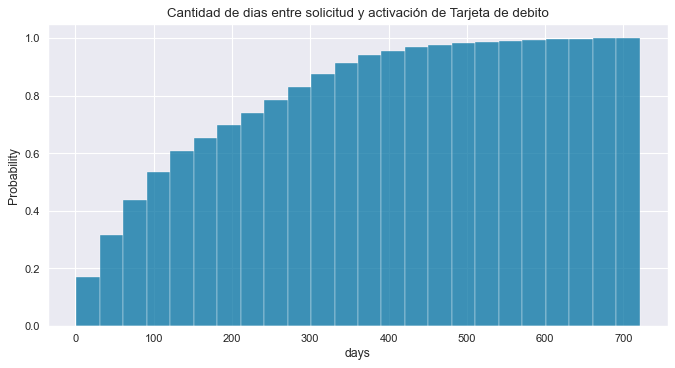

In [147]:
plt.figure(figsize=(10, 5), dpi=80)
sns.histplot(data=acti[acti.days >=0], x="days", stat="probability", binwidth=30, cumulative=True)
plt.title("Cantidad de dias entre solicitud y activación de Tarjeta de debito");

In [74]:
filtro_acti = acti.days > 0 

In [75]:
acti.days[filtro_acti].quantile(q=[0.33, 0.66])

0.33     63.0
0.66    185.0
Name: days, dtype: float64

In [76]:
def clasificar(x):
    if (x.days > 0) and (x.days < 60):
        return "0-60"
    elif (x.days >= 60) and (x.days < 180):
        return "60-180"
    else:
        return "+180"

In [77]:
acti["clas"] = acti.apply(clasificar, axis=1)

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/3198001745.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



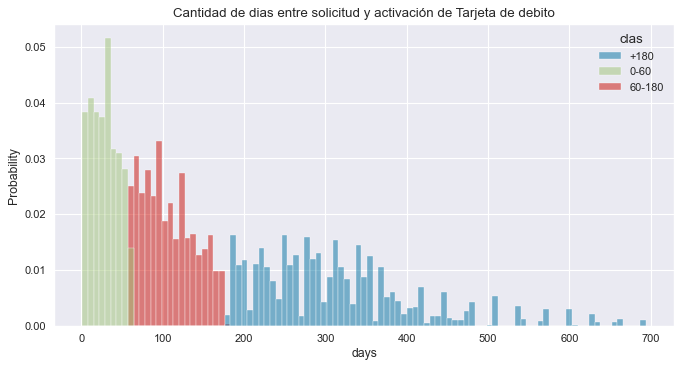

In [149]:
plt.figure(figsize=(10, 5), dpi=80)
sns.set_style("darkgrid")
sns.histplot(data=acti[acti.days >=0], x="days", stat="probability", binwidth=7, hue= "clas")
plt.title("Cantidad de dias entre solicitud y activación de Tarjeta de debito");

In [79]:
acti_dum = pd.get_dummies(acti, columns=["LYLT", "GEO_STATE"], drop_first=True)

In [80]:
X_acti = acti_dum.drop(columns=["dif_days", "days", "clas", "flag_activacion_td", "cus_cust_id", "fecha_solicitud","GEO_CITY", "fecha_activacion_td", "flag_actividad"], axis=1)

In [81]:
y_acti = acti.clas

In [82]:
cluster = pd.DataFrame(y_acti[filtro_acti].value_counts(normalize=True))
cluster["clas"] = round(cluster.clas,2)
cluster

clas
+180    0.35
60-180  0.34
0-60    0.31

In [141]:
fig_imp = px.bar(data_frame = cluster, y = cluster.index + " dias", x = "clas", 
             title="Cantidad de dias entre solicitud y activación de Tarjeta de debito",
             width=500, height=300, text = "clas", color = "clas", color_continuous_scale=px.colors.sequential.Bluered)
fig_imp.update_layout(xaxis_title = 'Proporción', yaxis_title = 'Dias', coloraxis_colorbar=dict(title="%"))             
fig_imp.show()  

In [84]:
# Separamos un set de testeo para evaluar el modelo
X_train_acti, X_test_acti, y_train_acti, y_test_acti = train_test_split(X_acti[filtro_acti], y_acti[filtro_acti], stratify=y_acti[filtro_acti], random_state = 0, test_size=0.3)

In [85]:
clf_acti = pickle.load(open("clf_acti.sav", 'rb'))

In [86]:
# pasos3_acti = [('scaler', StandardScaler()), ('lgb', lgb.LGBMClassifier())]
# pipe3_acti = Pipeline(pasos3_acti)
# search_space_acti = {'lgb__learning_rate': Real(0.01, 0.3, 'uniform'),
#                  'lgb__max_depth': Integer(3, 12),
#                  'lgb__subsample': Real(0.1, 1.0, 'uniform'),
#                 "lgb__num_leaves": Integer(20,3000),
#                  'lgb__colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
#                  'lgb__reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
#                  'lgb__reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
#                  'lgb__n_estimators': Integer(50, 1000),
#                 "lgb__min_child_samples": Integer(200,10000),
#                 "lgb__min_split_gain": Integer(0,15)
#    }

# folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

# #Instanciamos el objeto BayesSearchCV
# clf_acti = BayesSearchCV(
#     pipe3_acti,
#     search_spaces=search_space_acti,
#     cv=folds,
#     random_state=42, n_jobs=-1
# )

# clf_acti.fit(X_train_acti[filtro_acti],y_train_acti[filtro_acti])

In [87]:
clf_acti.best_score_

0.4539187593190482

In [88]:
clf_acti.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('lgb',
                 LGBMClassifier(colsample_bytree=0.8223985184900211,
                                learning_rate=0.0136193537638261, max_depth=3,
                                min_child_samples=200, min_split_gain=0,
                                n_estimators=1000, num_leaves=20,
                                reg_alpha=1e-09, reg_lambda=1e-09,
                                subsample=0.1))])

In [150]:
from yellowbrick.classifier import ROCAUC
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={"0-60": '<60 dias', 
                                        "60-180": '60 a 180 dias', 
                                        "+180": '+ de 180 dias'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show();
    
    return visualizer

In [136]:
print("ROC AUC Score Train:", roc_auc_score(y_train_acti[filtro_acti], clf_acti.predict_proba(X_train_acti[filtro_acti]), multi_class="ovr", average="macro"))

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/2930164563.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



ROC AUC Score Train: 0.645020354269522


Set de entrenamiento


C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/2331435341.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



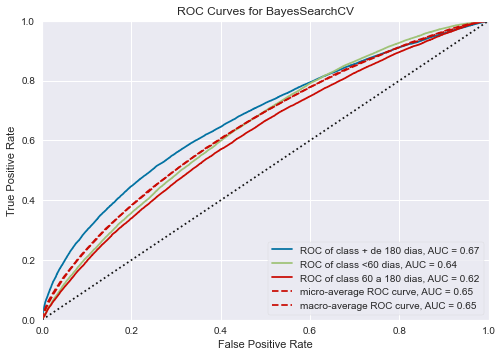

C:\Users\ariel.dapia\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\base.py:209: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

C:\Users\ariel.dapia\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\base.py:209: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for BayesSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None,
       encoder={'+180': '+ de 180 dias', '0-60': '<60 dias',
                '60-180': '60 a 180 dias'},
       estimator=BayesSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
                               estimator=Pipeline(steps=[('scaler',
                                                          StandardScaler()),
                                                         ('lgb',
                                                          L...
                                              'lgb__n_estimators': Integer(low=50, high=1000, prior='uniform', transform='normalize'),
                                              'lgb__num_leaves': Integer(low=20, high=3000, prior='uniform', transform='normalize'),
                                              'lgb__reg_alpha': Real(low=1e-09, high=100.0, prior='uniform'

In [152]:
print("Set de entrenamiento")
plot_ROC_curve(clf_acti, X_train_acti[filtro_acti], y_train_acti[filtro_acti], X_train_acti[filtro_acti], y_train_acti[filtro_acti])

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/871368592.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



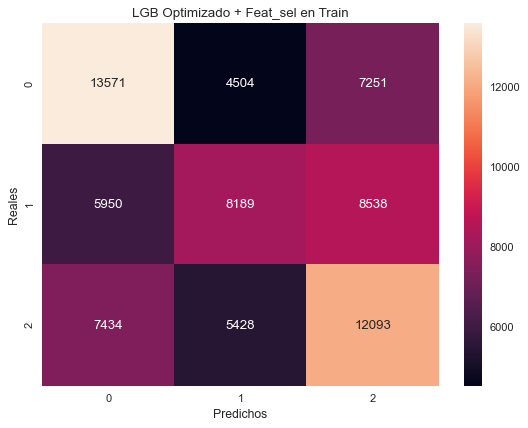

In [154]:
plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(confusion_matrix(y_train_acti[filtro_acti], clf_acti.predict(X_train_acti[filtro_acti])), annot=True, fmt='4d')
plt.title("LGB Optimizado + Feat_sel en Train")
plt.xlabel('Predichos');
plt.ylabel('Reales');

Set de evaluacion


C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/1437022766.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



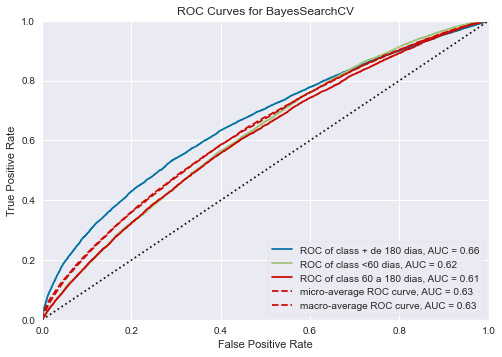

C:\Users\ariel.dapia\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\base.py:209: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

C:\Users\ariel.dapia\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\base.py:209: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for BayesSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None,
       encoder={'+180': '+ de 180 dias', '0-60': '<60 dias',
                '60-180': '60 a 180 dias'},
       estimator=BayesSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
                               estimator=Pipeline(steps=[('scaler',
                                                          StandardScaler()),
                                                         ('lgb',
                                                          L...
                                              'lgb__n_estimators': Integer(low=50, high=1000, prior='uniform', transform='normalize'),
                                              'lgb__num_leaves': Integer(low=20, high=3000, prior='uniform', transform='normalize'),
                                              'lgb__reg_alpha': Real(low=1e-09, high=100.0, prior='uniform'

In [156]:
print("Set de evaluacion")
plot_ROC_curve(clf_acti, X_train_acti[filtro_acti], y_train_acti[filtro_acti], X_test_acti[filtro_acti], y_test_acti[filtro_acti])

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/1709780829.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



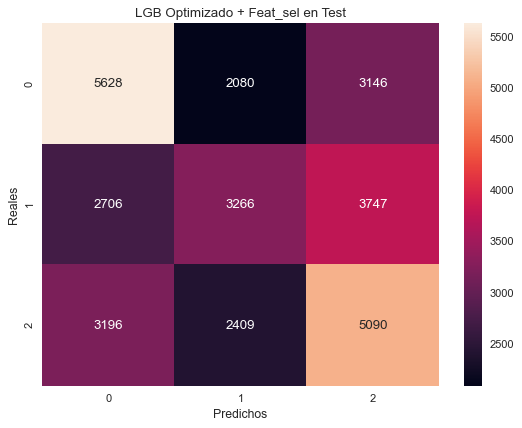

In [155]:
plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(confusion_matrix(y_test_acti[filtro_acti], clf_acti.predict(X_test_acti[filtro_acti])), annot=True, fmt='4d')
plt.title("LGB Optimizado + Feat_sel en Test")
plt.xlabel('Predichos');
plt.ylabel('Reales');

In [361]:
clf_acti_select = pd.DataFrame({'atributo':X_train_acti[filtro_acti].columns, 'importancia': clf_acti.best_estimator_.named_steps.lgb.feature_importances_})
clf_acti_select.sort_values('importancia', ascending = False).head(5)

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/980167625.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



atributo  importancia
2           tpn_month         3229
3           tpv_month         2514
4       tpn_billetera         2367
8  tpn_pagos_commerce         2150
9            dias_ult         2045

In [330]:
one_pred = clf_acti.predict_proba(X_test_acti[filtro_acti].iloc[100].values.reshape(1, -1))

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_23316/2700813543.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [331]:
fig_days = px.bar(x = ["0-60", "60-180", "+60"], y = one_pred[0], 
             title="Dias a activar la tarjeta de débito",
             width=400, height=500, text = np.round(one_pred[0],2), color=one_pred[0], color_continuous_scale=px.colors.sequential.Bluered)
fig_days.update_layout(xaxis_title = 'Dias', yaxis_title = 'Probabilidad', coloraxis_colorbar=dict(title="%"))
fig_days.show()  

# Analisis de Serie de tiempo

In [157]:
data = acti[filtro_acti].copy()

In [158]:
data['fecha_activacion_td'] = pd.to_datetime(data['fecha_activacion_td'])

In [159]:
data.sort_values(by="fecha_activacion_td", inplace=True)

In [160]:
data.index = data.fecha_activacion_td

In [161]:
# st = data["flag_activacion_td"].groupby(data.index).sum("flag_activacion_td")/data["flag_activacion_td"].groupby(data.index).count()

In [162]:
st = data["flag_activacion_td"].groupby(data.index).sum("flag_activacion_td")
data_tem = pd.DataFrame(st)

In [164]:
# correct_days = pd.DataFrame(index=pd.date_range(start="2021-01-09", end='2022-01-01'))
# data_tem = correct_days.join(data_tem)
# data_tem["flag_activacion_td"].fillna(0.1, inplace=True)

In [165]:
correct_days = pd.DataFrame(index=pd.date_range(start="2021-01-09", end='2022-01-01'))
correct_days = correct_days.join(data_tem)
correct_days["flag_activacion_td"].fillna(0.1, inplace=True)

In [166]:
data_tem["dia"] = data_tem.index.weekday + 1 
# data_tem["dia"] = data_tem.index.month
data_tem["timeIndex"] = np.arange(len(data_tem.index))

In [168]:
data_tem["date"] = data_tem.index

In [169]:
dummies_mes = pd.get_dummies(data_tem['dia'], drop_first=True, prefix='dia')
data_tem = data_tem.join(dummies_mes)

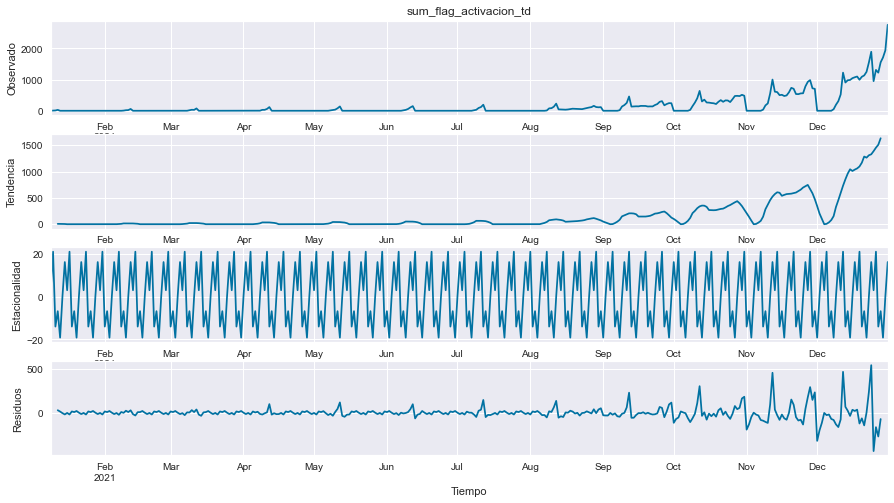

In [170]:
decomposition = sm.tsa.seasonal_decompose(correct_days[correct_days.index < "2022-01-01"]["flag_activacion_td"], model='additive')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))

decomposition.observed.plot(ax=ax1)
ax1.set_title("sum_flag_activacion_td")
ax1.set(ylabel="Observado")

decomposition.trend.plot(ax=ax2)
ax2.set(ylabel="Tendencia")

decomposition.seasonal.plot(ax=ax3)
ax3.set(ylabel="Estacionalidad")

decomposition.resid.plot(ax=ax4)
ax4.set(xlabel= "Tiempo", ylabel="Residuos");

In [171]:
# Función que plotea la serie:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

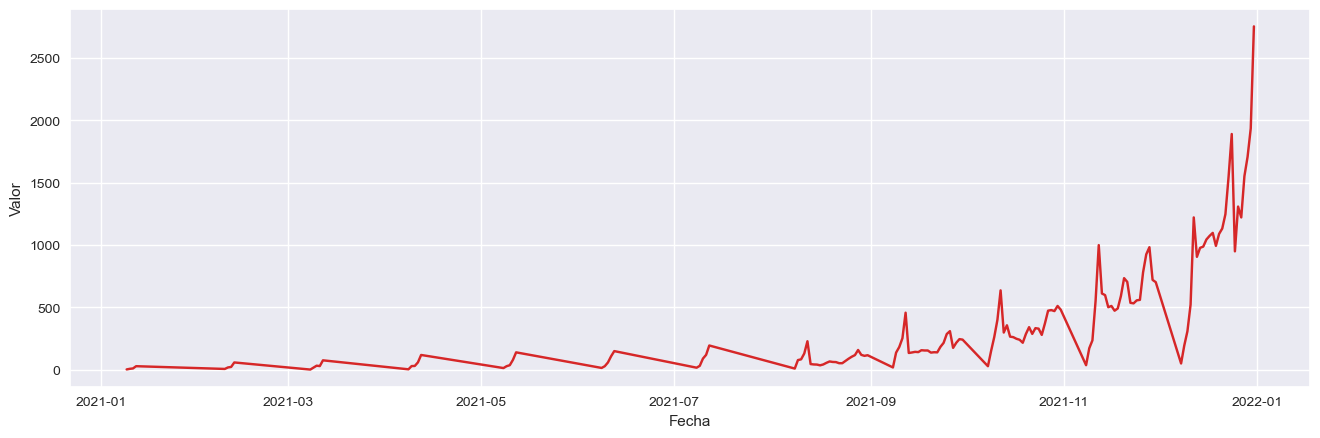

In [172]:
plot_df(data_tem[data_tem.index < "2022-01-01"]["flag_activacion_td"], data_tem[data_tem.index < "2022-01-01"]["flag_activacion_td"].index, data_tem[data_tem.index < "2022-01-01"]["flag_activacion_td"].values)

In [173]:
df_train, df_test = train_test_split(data_tem[data_tem.index < "2022-01-01"], test_size=21, random_state=42, shuffle=False)

In [174]:
tscv = TimeSeriesSplit(n_splits=5)

In [175]:
tscv.split(df_train.loc[:, ["timeIndex", "dia_2","dia_3","dia_4","dia_5","dia_6","dia_7"]])

<generator object TimeSeriesSplit.split at 0x000001E52F3B9970>

In [176]:
df_train['log_acti'] = np.log(df_train['flag_activacion_td'])
df_test['log_acti'] = np.log(df_test['flag_activacion_td'])

In [177]:
model_1 = smf.ols('log_acti ~ timeIndex + dia_2 + dia_3 + dia_4 + dia_5 + dia_6 + dia_7',\
                          data = df_train).fit()

In [178]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_acti   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     35.66
Date:                Wed, 26 Jan 2022   Prob (F-statistic):           1.10e-26
Time:                        20:01:14   Log-Likelihood:                -150.75
No. Observations:                 130   AIC:                             317.5
Df Residuals:                     122   BIC:                             340.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7564      0.217     12.708      0.000       2.327       3.186
timeIndex      0.0292      0.002     15.699      0.000       0.026       0.033
dia_2          0.1180      0.258      0.457      0.649      -0.394       0.630
dia_3          0.0478      0.262      0.183      0.855      -0.471       0.567
dia_4          0.1376      0.258      0.532      0.595      -0.374       0.649
dia_5          0.2868      0.258      1.110      0.269      -0.225       0.799
dia_6          0.2613      0.262      0.998      0.320      -0.257       0.780
dia_7          0.2693      0.262      1.028      0.306      -0.249       0.788
==============================================================================
Omnibus:                       42.033   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.447
Skew:                          -1.347   Prob(JB):                     1.39e-20
Kurtosis:                       6.102   Cond. No.                         550.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [179]:
df_train.loc[:,['model_1']] = model_1.predict(df_train[["timeIndex", "dia_2", "dia_3", "dia_4", "dia_5", "dia_6", "dia_7"]])


df_test.loc[:,['model_1']] = model_1.predict(df_test[["timeIndex", "dia_2", "dia_3", "dia_4", "dia_5", "dia_6", "dia_7"]])

In [180]:
df_train['back_model_1'] = np.exp(df_train['model_1'])
df_test['back_model_1'] = np.exp(df_test['model_1'])

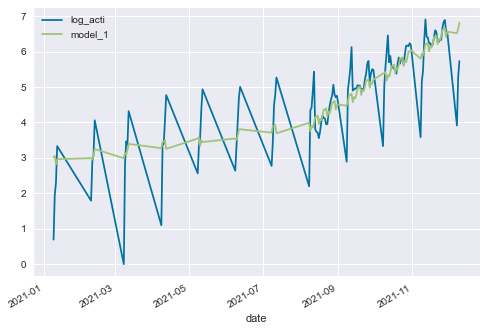

In [181]:
df_train.plot(kind = "line", x = "date", y = ['log_acti', 'model_1']);

In [182]:
print("RMSE log:", mean_squared_error(df_train['model_1'], df_train['log_acti'], squared=False))
print("r2 log:", r2_score(df_train['model_1'], df_train['log_acti']))

RMSE log: 0.7715605833239705
r2 log: 0.5112656462218457


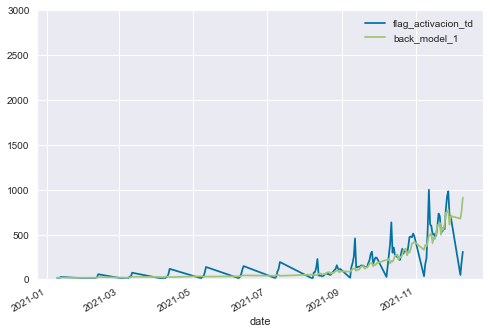

In [183]:
df_train.plot(kind = "line", x = "date", y = ['flag_activacion_td', 'back_model_1'], ylim=[0,3000]);

In [184]:
print("RMSE:", mean_squared_error(df_train['back_model_1'], df_train['flag_activacion_td'], squared=False))
print("r2:", r2_score(df_train['back_model_1'], df_train['flag_activacion_td']))

RMSE: 134.7182853926913
r2: 0.5951347111768099


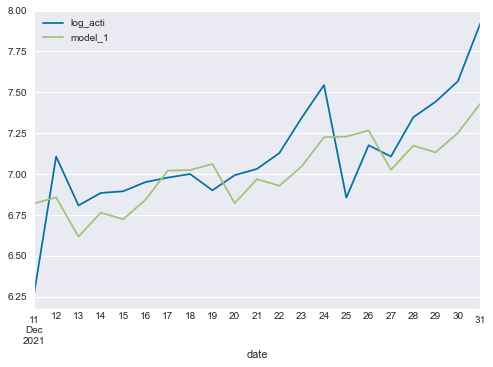

In [185]:
df_test.plot(kind = "line", x = "date", y = ['log_acti', 'model_1']);

In [186]:
print("RMSE log:", mean_squared_error(df_test['model_1'], df_test['log_acti'], squared=False))
print("r2 log:", r2_score(df_test['model_1'], df_test['log_acti']))

RMSE log: 0.25661725169239535
r2 log: -0.5885667583912118


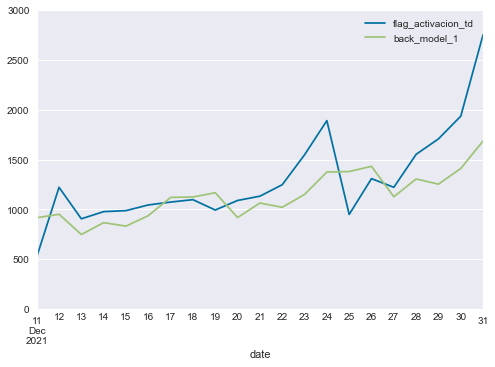

In [187]:
df_test.plot(kind = "line", x = "date", y = ['flag_activacion_td', 'back_model_1'], ylim=[0,3000]);

In [188]:
print("RMSE:", mean_squared_error(df_test['back_model_1'], df_test['flag_activacion_td'], squared=False))
print("r2:", r2_score(df_test['back_model_1'], df_test['flag_activacion_td']))

RMSE: 360.7645982984676
r2: -1.4186548205212768


# ARIMA

In [ ]:
res_model = df_train['log_acti'] - df_train['model_1']

plt.plot(df_train.timeIndex, res_model, '-');

In [ ]:
res_model_corr_days = pd.DataFrame(index=pd.date_range(start="2021-01-09", end='2021-12-10'))

In [ ]:
res_model_df = pd.DataFrame(res_model)

In [ ]:
res_model_df = res_model_corr_days.join(res_model_df)
res_model_df[0].fillna(0, inplace=True)

In [ ]:
res_model = res_model_df[0]

In [ ]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
# Corremos la función con nuestra serie res_log:

tsplot(res_model, lags=20)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
model_ARIMA = ARIMA(res_model, order=(1,0,1))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

In [ ]:
print(results_ARIMA.summary())

In [ ]:
plt.figure(figsize=(7,3.5))
res_model.plot()
results_ARIMA.fittedvalues.plot();

In [ ]:
res_ARIMA =  results_ARIMA.fittedvalues - res_model

In [ ]:
tsplot(res_ARIMA, lags=20)

In [ ]:
predictions_ARIMA= results_ARIMA.forecast(len(df_test['flag_activacion_td']), alpha=0.05)

In [ ]:
df_train['model_ARIMA'] = df_train['model_1'] + results_ARIMA.fittedvalues

df_test['model_ARIMA'] = df_test['model_1'] + predictions_ARIMA

In [ ]:
df_train.plot(kind = "line", x = "date", y = ['log_acti', 'model_ARIMA']);

In [ ]:
RMSE(df_train['model_ARIMA'], df_train['flag_activacion_td'])

In [ ]:
df_test.plot(kind = "line", x = "date", y = ['log_acti', 'model_ARIMA']);

In [ ]:
print("RMSE log:", mean_squared_error(df_test['model_ARIMA'], df_test['log_acti'], squared=False))
print("r2 log:", r2_score(df_test['model_ARIMA'], df_test['log_acti']))

In [ ]:
print("RMSE log:", mean_squared_error(df_test['model_ARIMA'], df_test['log_acti'], squared=False))
print("r2 log:", r2_score(np.exp(df_test['model_ARIMA']), np.exp(df_test['log_acti'])))